# Praktikum 10 Teks Classification: Naive Bayes

<pre>
Nama    : Raihan Rahmanda Junianto
NIM     : 222112303
Kelas   : 3SD2
</pre>

<hr>

## A. Penyiapan Library dan Dataset

In [1]:
### 1. Tahap Persiapan
# Import package/library yang diperlukan
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# untuk pre-processing teks
import re, string

# bag of words
from sklearn.feature_extraction.text import TfidfVectorizer

#untuk pembangunan model
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report, f1_score, accuracy_score, confusion_matrix

In [2]:
# Uncomment baris-baris berikut jika file data training disimpan di komputer
import os
# os.chdir('/Users/xxx/Documents/')
df_train=pd.read_csv('D:/RAIHAN STIS/Perkuliahan/SEMESTER 5/Praktikum INFORMATION RETRIEVAL/Pertemuan (10)/train0.csv')
print(df_train.shape)
df_train.head()
# Baris-baris berikut digunakan jika file data training disimpan di Google Drive
# from google.colab import drive
# drive.mount("/content/drive", force_remount=True)
# df_train=pd.read_csv('/content/drive/MyDrive/kuliah/Information Retrieval 22-23/Bahan Modul/bahan_latihan10/train0.csv')
# print(df_train.shape)
# df_train.head()

(3638, 2)


,sentence,sentiment
0,Kangen NaBil @RealSyahnazS @bangbily RaGa @Raf...,1
1,Doa utk orang yg mberi makan: Ya Allah! Berila...,1
2,"Setiap kali HP aku bunyi, aku selalu berharap ...",1
3,Belum pernah sedekat ini wawancara dgn Afgan S...,1
4,Dulu masa first pergi award show amatlah malas...,1


In [3]:
df_test=pd.read_csv('D:/RAIHAN STIS/Perkuliahan/SEMESTER 5/Praktikum INFORMATION RETRIEVAL/Pertemuan (10)/test0.csv')
print(df_test.shape)
df_test.head()

(1011, 2)


,sentence,sentiment
0,#Sports Perempuan Golkar Makassar Dibekali Ilm...,1
1,"Se-jauh""nya, Se-kenal""nya, Se-pisah""nya, Se-cu...",1
2,Sekedar Shared Ucapan Terimakasih Charles Hono...,1
3,Wah pak Jokowi sudah mendapat nilai positif di...,1
4,Penelpon : raffi ahmad oh raffi ahmad..... *bu...,1


## B. Analisis Data Eksploratif

sentiment
0    2567
1    1071
Name: count, dtype: int64


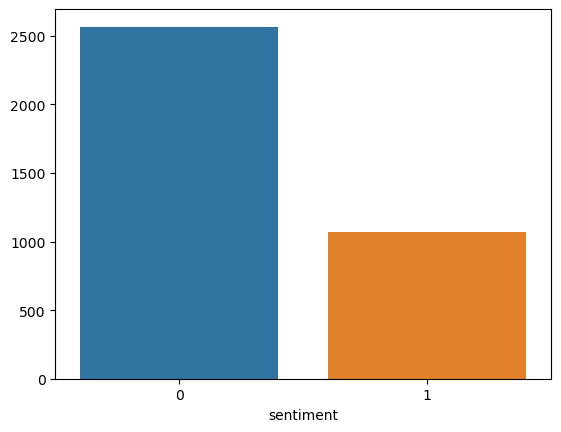

In [5]:
# CLASS DISTRIBUTION
# mengecek apakah dataset yang digunakan balance atau tidak
x = df_train['sentiment'].value_counts()
print(x)
sns.barplot(x = x.index, y = x.values)  # Use x.values for the y-axis data
plt.show()


In [6]:
# Memeriksa missing values
df_train.isna().sum()

sentence     0
sentiment    0
dtype: int64

In [8]:
#1. WORD-COUNT
print("Word Count")
df_train['word_count'] = df_train['sentence'].apply(lambda x:
len(str(x).split()))
print(df_train[df_train['sentiment']==1]['word_count'].mean()) #Positive
print(df_train[df_train['sentiment']==0]['word_count'].mean()) #Negative

#2. CHARACTER-COUNT
print("\nCharacter Count")
df_train['char_count'] = df_train['sentence'].apply(lambda x: len(str(x)))
print(df_train[df_train['sentiment']==1]['char_count'].mean()) #Positive
print(df_train[df_train['sentiment']==0]['char_count'].mean()) #Negative

#3. UNIQUE WORD-COUNT
print("\nUnique Word Count")
df_train['unique_word_count'] = df_train['sentence'].apply(lambda x:
len(set(str(x).split())))
#Positive
print(df_train[df_train['sentiment']==1]['unique_word_count'].mean())

#Negative
print(df_train[df_train['sentiment']==0]['unique_word_count'].mean())


Word Count
16.985060690943044
16.684456564082588

Character Count
121.1484593837535
111.01051811453058

Unique Word Count
16.166199813258636
15.502532138683287


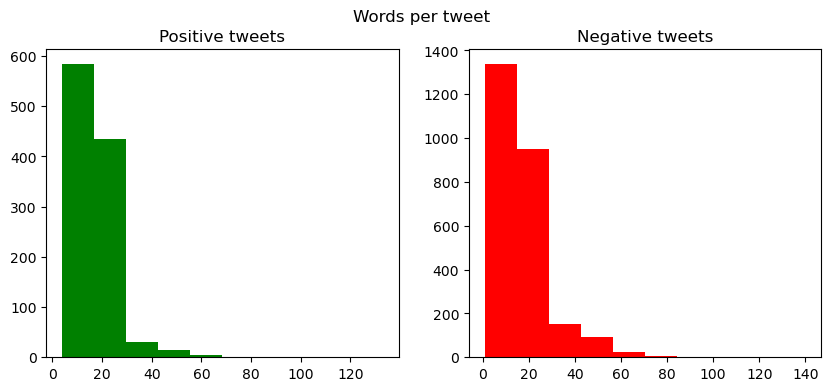

In [9]:
# Plotting word-count per tweet
fig,(ax1,ax2)=plt.subplots(1,2,figsize=(10,4))
train_words=df_train[df_train['sentiment']==1]['word_count']
ax1.hist(train_words,color='green')
ax1.set_title('Positive tweets')
train_words=df_train[df_train['sentiment']==0]['word_count']
ax2.hist(train_words,color='red')
ax2.set_title('Negative tweets')
fig.suptitle('Words per tweet')
plt.show()
df_train=df_train.drop(columns=['word_count','char_count','unique_word_count'])

## C. Pre-processing Data

In [10]:
# untuk pre-processing teks
#1. Common text preprocessing
text = "@user Teks ini mau dibersihkan. Ada beberapa karakter seperti: <br>, ?, :, '' spasi berlebih dan tab . "
# mengubah ke huruf kecil (lowercase) dan menghapus tanda baca, karakter aneh dan strip
def preprocess(text):
    text = text.lower() #lowercase text
    text = text.strip() #Menghapus leading/trailing whitespace
    text = re.sub('@[^\s]+','atUser',text) #mengubah @user menjadi atUser
    text = re.sub(r'#([^\s]+)', r'\1', text) #menghapus hashtag di depan suatu kata
    text= re.compile('<.*?>').sub('', text) #Menghapus HTML tags/markups
    text = re.compile('[%s]' % re.escape(string.punctuation)).sub(' ', text)

    #Replace punctuation with space. Careful since punctuation can sometime be useful
    text = re.sub('\s+', ' ', text) #Menghapus extra space dan tabs
    text = re.sub(r'\[[0-9]*\]',' ',text) #[0-9] matches any digit (0 to 10000...)
    text = re.sub(r'[^\w\s]', '', str(text).strip())
    text = re.sub(r'\d',' ',text) #matches any digit from 0 to 100000..., \D matches non-digits
    text = re.sub(r'\s+',' ',text) #\s matches any whitespace, \s+ matches multiple whitespace, \S matches non-whitespace
    return text

preprocess(text)

'atUser teks ini mau dibersihkan ada beberapa karakter seperti spasi berlebih dan tab'

In [11]:
def tokenisasi(text):
    tokens = text.split(" ")
    return tokens
#STOPWORD ELIMINATION DAN STEMMING
def stemming(text, stemmer):
    # stemming process
    output = stemmer.stem(text)
    return output
def stemming_stopword_elim(text, stopwords, stemmer):
    output = ""
    for token in tokenisasi(text):
        if not token in stopwords:
            output = output + stemming(token, stemmer) + " "
    return output[:-1]

In [12]:
#FINAL PREPROCESSING
from spacy.lang.id import Indonesian
import spacy
nlp = Indonesian() # use directly
nlp = spacy.blank('id') # blank instance'
stopwords = nlp.Defaults.stop_words
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory
# create stemmer
factory = StemmerFactory()
stemmer = factory.create_stemmer()

In [13]:
def finalpreprocess(string, stopwords, stemmer):
    return stemming_stopword_elim(preprocess(string), stopwords, stemmer)

In [14]:
df_train['clean_text'] = df_train['sentence'].apply(lambda x:finalpreprocess(x, stopwords, stemmer))
df_train.head()

,sentence,sentiment,clean_text
0,Kangen NaBil @RealSyahnazS @bangbily RaGa @Raf...,1,kangen nabil atuser atuser raga atuser atuser ...
1,Doa utk orang yg mberi makan: Ya Allah! Berila...,1,doa utk orang yg mberi makan ya allah ilah ber...
2,"Setiap kali HP aku bunyi, aku selalu berharap ...",1,kali hp bunyi harap
3,Belum pernah sedekat ini wawancara dgn Afgan S...,1,dekat wawancara dgn afgan syahreza updateblog ...
4,Dulu masa first pergi award show amatlah malas...,1,first pergi award show malas nak pikir baju sk...


In [17]:
df_test['clean_text'] = df_test['sentence'].apply(lambda x:finalpreprocess(x, stopwords, stemmer))
df_test.head()

,sentence,sentiment,clean_text
0,#Sports Perempuan Golkar Makassar Dibekali Ilm...,1,sports perempuan golkar makassar bekal ilmu pr...
1,"Se-jauh""nya, Se-kenal""nya, Se-pisah""nya, Se-cu...",1,nya kenal nya pisah nya cuek nya gengsi nya ka...
2,Sekedar Shared Ucapan Terimakasih Charles Hono...,1,dar shared ucap terimakasih charles honor http...
3,Wah pak Jokowi sudah mendapat nilai positif di...,1,jokowi nilai positif mata fraksi demokrat ayo ...
4,Penelpon : raffi ahmad oh raffi ahmad..... *bu...,1,telpon raffi ahmad oh raffi ahmad rem uculllll...


## D. Ekstraksi Feature dari Data Teks

In [18]:
X_train = df_train['clean_text']
y_train = df_train['sentiment']
X_test = df_test['clean_text']
y_test = df_test['sentiment']
# TF-IDF
# Konversi x_train ke vector karena model hanya dapat memproses angka, bukan kata/karakter
tfidf_vectorizer = TfidfVectorizer(use_idf=True)
X_train_vectors_tfidf = tfidf_vectorizer.fit_transform(X_train)
# tfidf digunakan pada kalimat yang belum ditokenisasi, berbeda dengan word2vec
# Hanya men-transform x_test (bukan fit dan transform)
X_test_vectors_tfidf = tfidf_vectorizer.transform(X_test)
# Jangan melakukan fungsi fit() TfidfVectorizer ke data testing karena hal itu akan
# mengubah indeks kata & bobot sehingga sesuai dengan data testing. Sebaliknya, lakukan
# fungsi fit pada data training, lalu gunakan hasil model pada data training tadi pada
# data testing untuk menunjukkan fakta bahwa Anda menganalisis data testing hanya
# berdasarkan apa yang dipelajari tanpa melihat data testing itu sendiri sebelumnya

## E. Pembangunan Model Klasifikasi Teks dengan Naive Bayes

In [19]:
"""#### NB (tf-idf)"""
nb_tfidf = MultinomialNB()
nb_tfidf.fit(X_train_vectors_tfidf, y_train) #model

#Melakukan prediksi nilai y pada dataset testing
y_predict = nb_tfidf.predict(X_test_vectors_tfidf)
y_prob = nb_tfidf.predict_proba(X_test_vectors_tfidf)[:,1]

## F. Evaluasi Model Klasifikasi

In [20]:
print(classification_report(y_test,y_predict))
print('Confusion Matrix:',confusion_matrix(y_test, y_predict))

              precision    recall  f1-score   support

           0       0.79      0.95      0.86       713
           1       0.77      0.41      0.54       298

    accuracy                           0.79      1011
   macro avg       0.78      0.68      0.70      1011
weighted avg       0.79      0.79      0.77      1011

Confusion Matrix: [[677  36]
 [176 122]]


## G. Kesimpulan

1. Precision (presisi):
   - Precision untuk kelas 0 (Negative): 0.79
   - Precision untuk kelas 1 (Positive): 0.77

   Precision mengukur sejauh mana model benar-benar memprediksi kelas tertentu dengan benar. Dalam hal ini, untuk kelas 0 (Negatif), model benar-benar memprediksi dengan benar sekitar 79% dari semua prediksi yang dilakukan untuk kelas tersebut. Sedangkan, untuk kelas 1 (Positif), model benar-benar memprediksi dengan benar sekitar 77% dari semua prediksi yang dilakukan untuk kelas tersebut.

2. Recall (recall):
   - Recall untuk kelas 0 (Negative): 0.95
   - Recall untuk kelas 1 (Positive): 0.41

   Recall mengukur sejauh mana model dapat mendeteksi semua instance yang benar-benar termasuk dalam kelas tertentu. Dalam hal ini, untuk kelas 0 (Negatif), model dapat mendeteksi sekitar 95% dari semua instance yang seharusnya masuk ke dalam kelas tersebut. Namun, untuk kelas 1 (Positif), model hanya dapat mendeteksi sekitar 41% dari semua instance yang seharusnya masuk ke dalam kelas tersebut.

3. F1-Score (f1-score):
   - F1-Score untuk kelas 0 (Negative): 0.86
   - F1-Score untuk kelas 1 (Positive): 0.54

   F1-Score adalah perpaduan antara precision dan recall, yang berguna untuk mengukur keseluruhan kinerja model. Untuk kelas 0 (Negatif), F1-Score adalah 0.86, dan untuk kelas 1 (Positif), F1-Score adalah 0.54. F1-Score yang tinggi menunjukkan bahwa model memiliki keseimbangan yang baik antara precision dan recall.

4. Akurasi (accuracy):
   - Akurasi secara keseluruhan: 0.79

   Akurasi adalah rasio prediksi yang benar secara keseluruhan. Dalam hal ini, akurasi adalah sekitar 79%, yang berarti model ini benar sekitar 79% dari waktu saat memprediksi kelas dari keseluruhan data.

5. Macro Average dan Weighted Average:
   - Macro Average mengambil rata-rata metrik untuk setiap kelas tanpa memperhatikan distribusi kelas. Macro Average F1-Score adalah 0.70.
   - Weighted Average memberi bobot metrik berdasarkan jumlah sampel dalam setiap kelas. Weighted Average F1-Score adalah 0.77.

   Macro Average berguna jika kelas-kelas memiliki distribusi yang seimbang, sementara Weighted Average lebih akurat ketika kelas-kelas memiliki distribusi yang tidak seimbang. Weighted Average lebih tinggi karena memberikan lebih banyak bobot pada kelas mayoritas (kelas 0) yang memiliki lebih banyak sampel.
   
   Secara keseluruhan, model memiliki kinerja yang baik dalam memprediksi kelas 0 (Negatif), tetapi memiliki kinerja yang lebih rendah dalam memprediksi kelas 1 (Positif) berdasarkan nilai recall dan F1-Score yang lebih rendah. Akurasi model adalah 0.79, yang berarti model ini benar sekitar 79%.
